### Load models


In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import pickle as pkl

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation,gmm_evaluate_with_perturbation3, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, maxval
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [2]:
device = torch.device("cuda:1")
# Dataset params
dataset_num_classes = {"cifar10": 10, "CIFAR100": 100, "SVHN": 10, "LSUN": 10, "tiny_iamgenet": 200}

dataset_loader = {"cifar10": cifar10, "CIFAR100": cifar100, "SVHN": svhn, "MNIST": mnist, "LSUN": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512}

batch_size = 512
dataset = "cifar10"

dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run38/vgg16_sn_3.0_mod_seed_1/2024_11_26_01_05_50/vgg16_sn_3.0_mod_seed_1_best.model"

model = "resnet50"
saved_model_name = "../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]

In [3]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=False,
    val_seed=1,
    val_size=0.0,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

_ = net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
_ = net.eval()

load ../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.model


In [4]:
cache_path = saved_model_name.replace(".model", ".cache")

load_cache = True
if load_cache and os.path.exists(cache_path):
    print(f"load cache from {cache_path}")
    with open(cache_path, 'rb') as file:
        cache = pkl.load(file)
        embeddings = cache["embeddings"].to(device)
        labels = cache["labels"].to(device)
        norm_threshold = cache["norm_threshold"]
else:
    embeddings, labels, norm_threshold = get_embeddings(
        net,
        train_loader,
        num_dim=model_to_num_dim[model],
        dtype=torch.double,
        device=device,
        storage_device=device,
    )
    cache = {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "norm_threshold": norm_threshold}
    with open(cache_path, "wb") as f:
        pkl.dump(cache, f)    
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)                    

load cache from ../saved_models/run42/resnet50_sn_3.0_mod_seed_1/2025_01_10_19_24_27/resnet50_sn_3.0_mod_seed_1_best.cache


### Compute feature density


In [95]:
ood_dataset = "LSUN"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=512,sample_size=1000)
logits, labels, preds = gmm_evaluate(
    net,
    gaussians_model,
    None,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

ood_logits, ood_labels, _ = gmm_evaluate(
    net,
    gaussians_model,
    None,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
m1_fpr95, m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, maxval, device, conf=True)


m2_res = []
for epsilon in [0.001]:
    #test_loader必须放里面，否则循环每次load数据不一致
    test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
    ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1,sample_size=1000)
    logits2, labels2, preds2, acc, acc_perturb = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    ood_logits2, ood_labels2, _, _, _ = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        ood_test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(logits2, ood_logits2, maxval, device, conf=True)
    m2_res.append([m2_auroc, m2_auprc, logits2,ood_logits2, epsilon])
    print(f"noise-:m1_auroc:{m1_auroc:.4f},m1_auprc:{m1_auprc:.4f};noise+:epsilon:{epsilon},m2_auroc:{m2_auroc:.4f},m2_auprc:{m2_auprc:.4f}")

m2_auroc, m2_auprc,logits2,ood_logits2, epsilon = sorted(m2_res)[-1]  #从小到大排序，并且取最大的
print(f"最优:m1_auroc1:{m1_auroc:.4f},m1_auprc:{m1_auprc:.4f};epsilon:{epsilon},m2_auroc:{m2_auroc:.4f},m2_auprc:{m2_auprc:.4f}")


100%|██████████| 1000/1000 [01:53<00:00,  8.77it/s]

noise-:m1_auroc:0.9104,m1_auprc:0.9347;noise+:epsilon:0.001,m2_auroc:0.9268,m2_auprc:0.9397
最优:m1_auroc1:0.9104,m1_auprc:0.9347;epsilon:0.001,m2_auroc:0.9268,m2_auprc:0.9397


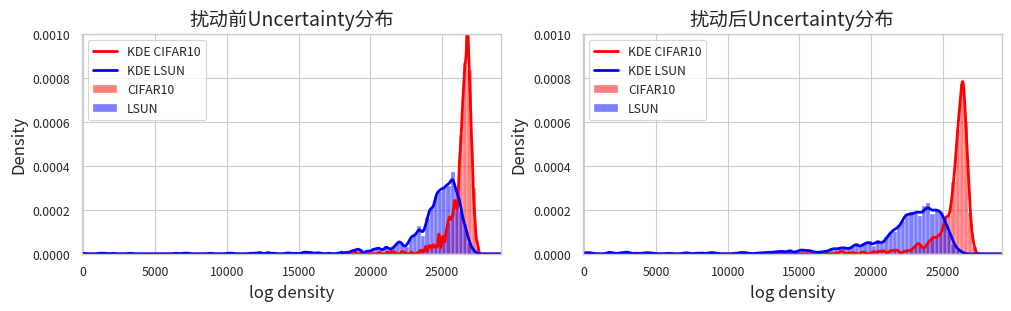

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde

# 确保Seaborn样式和上下文设置
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

# 设置字体路径（如果需要）
from matplotlib import rcParams, font_manager
import matplotlib
font_path = './fonts/NotoSansCJK-Regular.ttc'
font_prop = font_manager.FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()
matplotlib.rcParams['axes.unicode_minus'] = False  # 防止负号显示问题

def plot_density_subplots(results1, binrange1, bins1, title1, xlabel1,
                          results2, binrange2, bins2, title2, xlabel2, output_path,
                          bw_method=0.1):
    """
    绘制两个子图，分别显示不同情况下的密度直方图，纵轴统一。
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

    # 第一个子图
    # 绘制直方图
    sns.histplot(results1[0], kde=False, color='r', bins=bins1, binrange=binrange1, 
                 stat="density", label="CIFAR10", ax=axes[0], alpha=0.5)
    sns.histplot(results1[1], kde=False, color='b', bins=bins1, binrange=binrange1, 
                 stat="density", label=f"{ood_dataset}", ax=axes[0], alpha=0.5)
    
    # 手动计算并绘制 KDE（限制范围）
    filtered_r = results1[0][(results1[0] >= binrange1[0]) & (results1[0] <= binrange1[1])]
    filtered_b = results1[1][(results1[1] >= binrange1[0]) & (results1[1] <= binrange1[1])]
    
    kde_r = gaussian_kde(filtered_r, bw_method=bw_method)  # 控制带宽
    kde_b = gaussian_kde(filtered_b, bw_method=bw_method)  # 控制带宽
    
    # 设置绘制的 x 轴范围
    x_r = np.linspace(binrange1[0], binrange1[1], 1000)
    x_b = np.linspace(binrange1[0], binrange1[1], 1000)
    
    axes[0].plot(x_r, kde_r(x_r), color='r', label="KDE CIFAR10", linewidth=2)
    axes[0].plot(x_b, kde_b(x_b), color='b', label=f"KDE {ood_dataset}", linewidth=2)
    
    axes[0].set_xlabel(xlabel1, fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(title1, fontsize=14)
    axes[0].set_xlim(binrange1)  # 手动设置x轴范围
    axes[0].set_ylim([0,0.0010])  # 手动设置x轴范围
    axes[0].legend(loc='upper left')

    # 第二个子图
    # 绘制直方图
    sns.histplot(results2[0], kde=False, color='r', bins=bins2, binrange=binrange2, 
                 stat="density", label="CIFAR10", ax=axes[1], alpha=0.5)
    sns.histplot(results2[1], kde=False, color='b', bins=bins2, binrange=binrange2, 
                 stat="density", label=f"{ood_dataset}", ax=axes[1], alpha=0.5)
    
    # 手动计算并绘制 KDE（限制范围）
    filtered_r = results2[0][(results2[0] >= binrange2[0]) & (results2[0] <= binrange2[1])]
    filtered_b = results2[1][(results2[1] >= binrange2[0]) & (results2[1] <= binrange2[1])]
    
    kde_r = gaussian_kde(filtered_r, bw_method=bw_method)  # 控制带宽
    kde_b = gaussian_kde(filtered_b, bw_method=bw_method)  # 控制带宽
    
    # 设置绘制的 x 轴范围
    x_r = np.linspace(binrange2[0], binrange2[1], 1000)
    x_b = np.linspace(binrange2[0], binrange2[1], 1000)
    
    axes[1].plot(x_r, kde_r(x_r), color='r', label="KDE CIFAR10", linewidth=2)
    axes[1].plot(x_b, kde_b(x_b), color='b', label=f"KDE {ood_dataset}", linewidth=2)
    
    axes[1].set_xlabel(xlabel2, fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(title2, fontsize=14)
    axes[1].set_xlim(binrange2)  # 手动设置x轴范围
    axes[1].set_ylim([0,0.0010])  # 手动设置x轴范围
    axes[1].legend(loc='upper left')

    # 保存图像
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()

# 确保输出目录存在
if not os.path.exists(f"pngs/{model}"):
    os.makedirs(f"pngs/{model}")

# # 定义数据范围和参数
logp = maxval(logits).cpu().numpy()
logp2 = maxval(logits2).cpu().numpy()
ood_logp = maxval(ood_logits).cpu().numpy()
ood_logp2 = maxval(ood_logits2).cpu().numpy()

if os.path.exists(f"results/data_{model}_{ood_dataset}.npy"):
    data_dict = np.load(f"results/data_{model}_{ood_dataset}.npy",allow_pickle=True).item()
    print(type(data_dict))
    logp = data_dict["logp"]
    logp2 = data_dict["logp2"]
    ood_logp = data_dict["ood_logp"]
    ood_logp2 = data_dict["ood_logp2"]
else:
    # 存储数据到npy文件
    data_dict = {
        'logp': logp,
        'logp2': logp2,
        'ood_logp': ood_logp,
        'ood_logp2': ood_logp2
    }
    np.save(f"results/data_{model}_{ood_dataset}.npy", data_dict)



# 定义数据范围
left1, right1 = 0, 29000
left2, right2 = 0, 29000

# 调用绘图函数，设置带宽（例如 0.2）
plot_density_subplots(
    results1=[logp, ood_logp],
    binrange1=[left1 - 100, right1 + 100],
    bins1=100,
    title1="扰动前Uncertainty分布",
    xlabel1="log density",
    results2=[logp2, ood_logp2],
    binrange2=[left2 - 100, right2 + 100],
    bins2=100,
    title2="扰动后Uncertainty分布",
    xlabel2="log density",
    output_path=f'pngs/{model}/{ood_dataset}_logdensity_hist_subplots.png',
    bw_method=0.05  # 调整带宽
)


In [98]:
from PIL import Image

# 读取四张图片

img1 = Image.open("pngs/resnet50/MNIST_logdensity_hist_subplots.png")  # 替换为实际图片路径
img2 = Image.open("pngs/resnet50/SVHN_logdensity_hist_subplots.png")
img3 = Image.open("pngs/resnet50/LSUN_logdensity_hist_subplots.png")
img4 = Image.open("pngs/resnet50/CIFAR100_logdensity_hist_subplots.png")

# 确保所有图片宽度一致（可选）
width = img1.size[0]
img2 = img2.resize((width, img2.size[1]))
img3 = img3.resize((width, img3.size[1]))
img4 = img4.resize((width, img4.size[1]))

# 计算合成后图片的高度
total_height = img1.size[1] + img2.size[1] + img3.size[1] + img4.size[1]

# 创建一个新画布
combined_image = Image.new("RGB", (width, total_height))

# 将图片依次粘贴到画布上
y_offset = 0
for img in [img1, img2, img3, img4]:
    combined_image.paste(img, (0, y_offset))
    y_offset += img.size[1]  # 更新y轴偏移

# 保存合成后的图片
combined_image.save("combined_vertical_image.png")

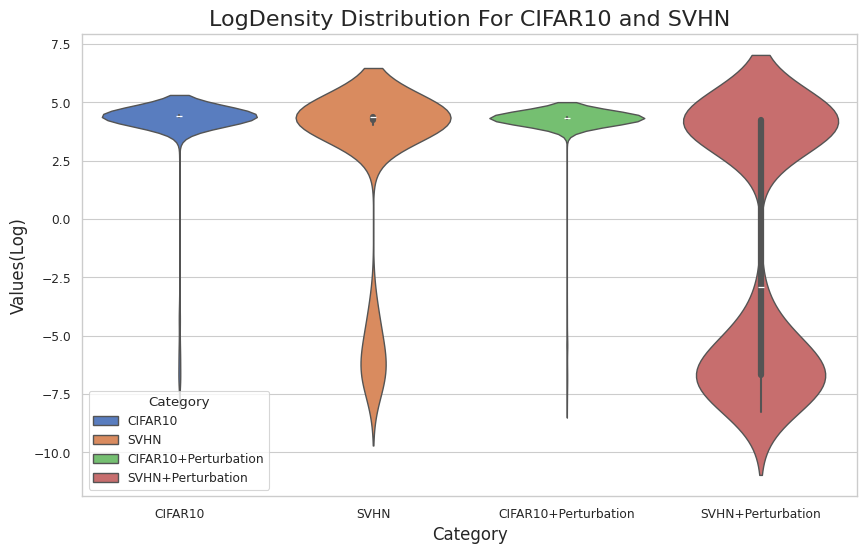

In [52]:
x1= np.sign(logp.cpu().numpy()) * np.log10(np.abs(logp.cpu().numpy()))  # 零值单独处理
x2= np.sign(logp2.cpu().numpy()) * np.log10(np.abs(logp2.cpu().numpy()))  # 零值单独处理
x3= np.sign(ood_logp.cpu().numpy()) * np.log10(np.abs(ood_logp.cpu().numpy()))  # 零值单独处理
x4= np.sign(ood_logp2.cpu().numpy()) * np.log10(np.abs(ood_logp2.cpu().numpy()))  # 零值单独处理
data = {
    "Values": np.concatenate([x1,x3,x2,x4]),
    "Category": np.repeat(['CIFAR10', f'{ood_dataset}', 'CIFAR10+Perturbation', f'{ood_dataset}+Perturbation'],1000)
}
df = pd.DataFrame(data)

# 绘制小提琴图
plt.figure(figsize=(10, 6))
sns.violinplot(x='Category', y='Values', hue='Category', data=df, palette='muted', inner='box', legend=True)
# sns.boxplot(x='Category', y='Values', hue='Category',data=df, palette='muted',showmeans=True,)

# 添加标题和标签
plt.title(f'LogDensity Distribution For CIFAR10 and {ood_dataset}', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Values(Log)', fontsize=12)

plt.savefig(f'pngs/{model}/{ood_dataset}_logdensity_violin_purturbation.png', bbox_inches='tight')

# 显示图表
plt.show()

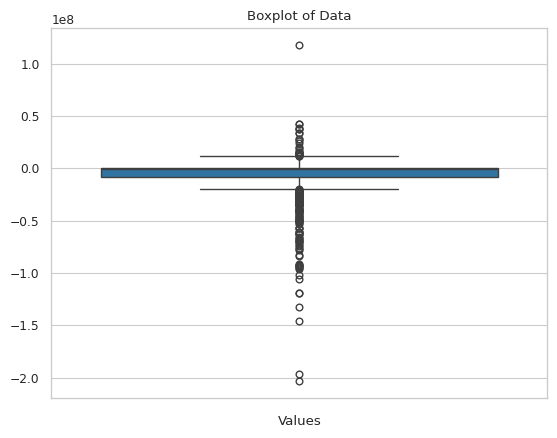

In [12]:
ood_diff = ood_logp2-ood_logp
sns.boxplot(data=ood_diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

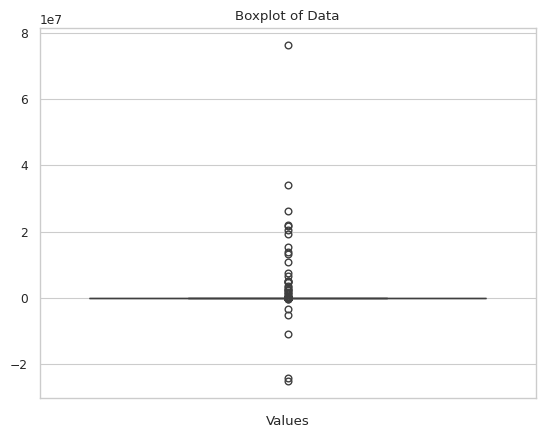

In [13]:
diff = logp2-logp
sns.boxplot(data=diff.cpu().numpy())

# 添加图标题和标签
plt.title("Boxplot of Data")
plt.xlabel("Values")

# 显示图形
plt.show()

In [14]:
diff

tensor([ 1.5966e+04,  1.0464e+03,  1.9215e+03, -2.1906e+03, -1.8654e+03,
        -6.9531e-01, -1.4362e+03,  3.8993e+03,  1.4558e+02,  6.4580e+02,
        -1.7121e+02, -1.6792e+02,  1.0238e+04,  1.4687e+03,  4.2701e+02,
        -6.8518e+01, -1.9115e+02,  4.2479e+02, -3.4684e+02,  5.7254e+02,
         3.5669e+04,  6.5793e+01,  2.6796e+02, -1.1854e+03,  2.6021e+02,
        -2.8828e+00, -8.3379e+01, -1.3398e+03, -1.0201e+04,  4.6692e+02,
         2.7168e+03, -2.7123e+02, -6.8759e+02,  1.7463e+03,  3.8270e+02,
         3.1627e+02,  2.9504e+02,  6.8141e+02,  2.2492e+01,  2.2991e+03,
         3.7498e+02,  7.6910e+01,  4.2300e+02,  2.9035e+02,  2.0766e+03,
        -3.7553e+01, -7.8574e+00,  4.2431e+02,  6.7990e+02,  7.9928e+02,
         1.8941e+03, -1.2868e+02,  2.3623e+03,  9.2948e+02, -5.2785e+01,
        -1.3759e+02,  5.2212e+02,  1.9645e+02, -5.1926e+02, -6.9826e+01,
         9.7911e+02,  2.2100e+02,  2.2432e+02,  1.8456e+02,  2.0749e+02,
         4.3862e+02,  2.5274e+03,  1.2470e+03,  1.7

In [129]:
diff[diff<0].shape[0]/1000

0.255

In [130]:
ood_diff

tensor([ 5.2129e+03,  9.1858e+05,  9.8092e+02,  1.0270e+04, -3.6312e+05,
         8.7199e+05,  4.7344e+03,  1.7492e+06,  7.6941e+03,  1.3670e+03,
         7.5254e+00,  3.0052e+03, -3.0530e+03,  1.2642e+03, -8.2831e+06,
         1.3857e+03,  1.0299e+03,  4.0376e+03,  2.0354e+03,  2.7188e+02,
         1.3825e+06, -4.8107e+02,  5.8002e+04,  6.7237e+03,  1.8472e+03,
         5.5687e+03, -6.7734e+06, -1.0380e+07,  9.7167e+03, -1.5617e+07,
        -9.9274e+02, -6.6020e+06,  1.5795e+03,  5.6269e+03, -7.6517e+06,
         4.7100e+03,  4.8603e+03,  1.3056e+03,  3.2238e+03,  1.2068e+04,
        -6.8058e+05,  1.0709e+04,  1.4753e+03,  3.9261e+04, -1.4259e+07,
        -2.3550e+03,  3.7283e+03, -6.7810e+07, -1.1356e+06, -1.4342e+07,
         4.4034e+03,  3.6279e+03,  1.7596e+03,  1.7906e+03, -6.8445e+02,
         2.5412e+03,  1.5038e+06, -2.0772e+03, -4.2037e+05, -2.2364e+03,
         4.3608e+05, -1.2383e+05,  7.3502e+04,  1.2637e+07,  2.0724e+03,
         2.4596e+03,  5.1866e+03,  1.7392e+03,  1.5

In [131]:
ood_diff[ood_diff<0].shape[0]/1000

0.313